<h1 align="center"> Lending Club Loan Analysis & Classification </h1>
<h2 align="right"> Jim Chung </h2>

## What is Lending Club?

<a src="https://en.wikipedia.org/wiki/Lending_Club"> Lending Club </a>
 is a  peer to peer lending company based in the United States, in which investors provide funds for potential borrowers and investors earn a profit depending on the risk they take (the borrowers credit score). Lending Club provides the "bridge" between investors and borrowers. For more basic information about the company please check out the wikipedia article about the company. 


## Data Descriptions:

These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. 

## Table of Contents:

I. <b>Introduction</b><br>
a) [General Information](#general_information)<br>

II. <b>Exploratory Data Analysis</b><br>
a) [Stochastic Distribution](#dist)<br>
b) [Loan Issurance by Year, Region, and Incom](#by_factors)<br>
c) [Elements of Good and Bad Loans](#good_bad)<br><br>

III. <b>The Business Perspective</b><br>
a) [Understanding the Operative side of Business](#operative_side)<br>
b) [Analysis by Income Category](#income_category) <br><br>

IV. <b>Assesing Risks</b><br>
a) [Understanding the Risky Side of Business](#risky_side)<br>
b) [The importance of Credit Scores](#credit_scores)<br>
c) [What determines a bad loan](#determines_bad_loan)<br>
d) [Defaulted Loans](#defaulted_loans)
e) [Risks by Purposes](#loan_condition)

In [76]:
import warnings
warnings.filterwarnings('ignore')

# Data Handling
import pandas as pd
import numpy as np
import seaborn as sns

# Modeling
from sklearn import ensemble
from sklearn.preprocessing import OneHotEncoder, Imputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, accuracy_score, classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Test
import scipy.stats as stats

# Iteration Helper
from tqdm import tqdm

%matplotlib inline

df = pd.read_csv("~/data/school/DA/loan.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835917 non-null object
emp_length                     842554 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

<br>
<br>
<a id="general_information"></a>
# Introduction

## General Information

The file is a matrix of about 890 thousand observations and 74 variables. The existance of missing values makes it important to apply data cleaning and feature engineering. I will suggest useful insights by visualization in the following chapter. Then, careful engineering will be applied to build a prediction for classifying bad loans.



In [77]:
print("Shape of dataframe: ", df.shape)

Shape of dataframe:  (887379, 74)


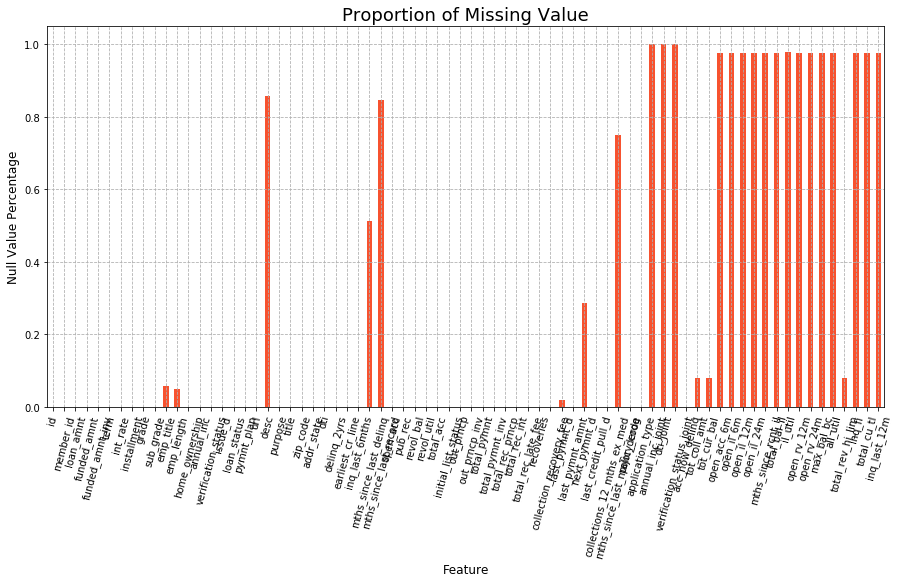

In [78]:
def nullity_plot(df, rot=75, figsize=(15, 7)):
    ax = (df.isnull().sum()/df.shape[0]).plot(kind='bar', figsize=figsize, color="#F7522F", rot=rot)
    plt.grid(True, linestyle='--')
    ax.set_xlabel("Feature", fontsize=12)
    ax.set_ylabel("Null Value Percentage", fontsize=12)
    ax.set_title('Proportion of Missing Value', fontsize=18)
    
nullity_plot(df)

In [79]:
# Rename features
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount",\
                        "funded_amnt_inv": "investor_funds", "last_pymnt_amnt":"last_pymnt_amount",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

# relevant columns for further analysis
col = 'loan_amount,funded_amount,emp_length,home_ownership,\
annual_income,last_pymnt_amount,total_pymnt,loan_status'.split(',')

ori_df = df.copy()
df = df[col]

# We are interested in 'loan status' variable
list(df.loan_status.unique())

['Fully Paid',
 'Charged Off',
 'Current',
 'Default',
 'Late (31-120 days)',
 'In Grace Period',
 'Late (16-30 days)',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Issued']

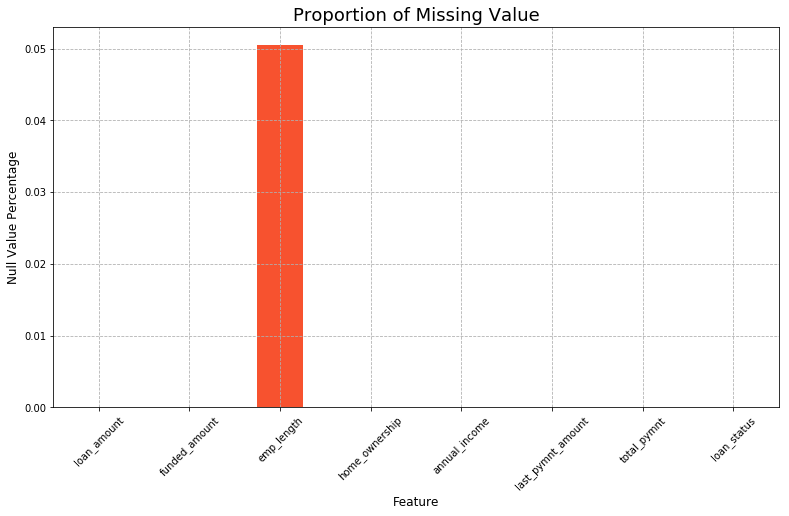

In [80]:
# See selected features have no or small number of missing values
nullity_plot(df, rot=45, figsize=(13,7))

Selected 8 features are as follows:

1. **loan_amount**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
2. **funded_amount**: The total amount committed to that loan at that point in time.
3. **emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
4. **home_ownership**: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
5. **annual_income**: The self-reported annual income provided by the borrower during registration.
6. **last_pymnt_amount**: Last total payment amount received.
7. **total_pymnt**: Payments received to date for total amount funded.<br>
8. **loan_status**: Current status of the loan.
    + 'Fully Paid'
    + 'Charged Off'
    + 'Current',
    + 'Default',
    + 'Late (31-120 days)',
    + 'In Grace Period',
    + 'Late (16-30 days)',
    + 'Does not meet the credit policy. Status:Fully Paid',
    + 'Does not meet the credit policy. Status:Charged Off',
    + 'Issued'

These variables have no or a small amount of missing values. Also, they are highly likely to be relavant to 'loan_status.'

<br>
<br>

# Exploratory Data Analysis

### Things to see
- Normality is missing
- Number of loan issurances over time
- Who borrow the loan?
- Indicators of bad loans

<a id="dist"></a>
## Stochastic Distribution

You will see the distribution of the loan amount is not well normally distributed. This seems reasonable considering the fact that people with low income will tend to borrow more than the rich. Plus, the interest rate of lending club is higher than that of banks. Large business loans would have been borrowed from other financial institutions.


Text(0.5,1,'Total committed by Investors')

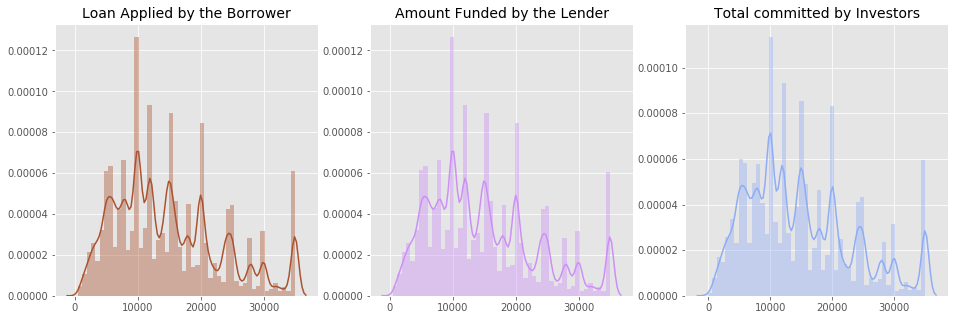

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = ori_df["investor_funds"].values

sns.distplot(loan_amount, ax=ax[0], color="#AB522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#CC8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#8EADF6")
ax[2].set_title("Total committed by Investors", fontsize=14)

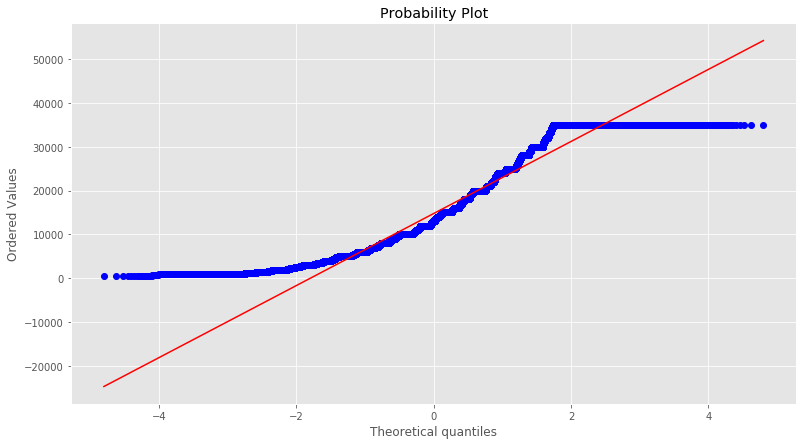

In [100]:
# QQ plot called. Normal distribution checked
plt.style.use('seaborn-bright')
plt.figure(figsize=(13,7))
ax = stats.probplot(loan_amount, dist="norm", plot=plt)
plt.grid(True)

<br>
<br>
<a id="by_factors"></a>
## Loan Issued by Year, Region, and Income

In [106]:
# Transform the issue dates by year.
ori_df['issue_d'].head()
dt_series = pd.to_datetime(ori_df['issue_d'])
df['year'] = dt_series.dt.year

Text(0,0.5,'Average Amount of Loans Issued')

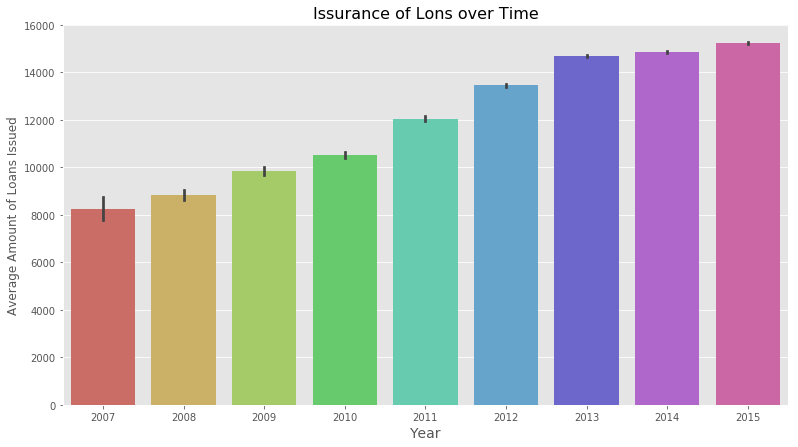

In [110]:
# Loan amounts along year.
# See the constant increasing pattern. This is attributed to low interate rate from fiancial crisis
# Also, the economy is recovering from the crisis
plt.figure(figsize=(13, 7))
sns.barplot('year', 'loan_amount', data=df, palette='hls')
plt.title('Issurance of Lons over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Amount of Loans Issued')

In [ ]:
# Over Regions
ori_df['sta']

In [45]:
# Preprocessing
X['emp_length'] = X['emp_length'].str.extract('(\d+)',)
X['home_ownership'] = X['home_ownership'].factorize(sort=True)[0]

# Missing Value
imputer = Imputer(strategy='median')
X = imputer.fit_transform(X)

# Test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

In [7]:
'''
# Grid search to find the optimal parameters
param_grid = [
    {'n_estimators': [10, 30], 'max_features': [2, 4, 6]}
]

# Fit random forests
clf = ensemble.RandomForestClassifier()

# accuracy is not a good metric for multi-class problems -> f1 score
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=scorer)

# Fit the data
grid_search.fit(X_train, y_train)

# Metrics
cvres = grid_search.cv_results_
for f1_score, params in zip(cvres['f1_score'], cvres['params']):
    print(f1_score, params)
'''

In [ ]:
score = []
param_n = [5, 10, 30, 60]


for n in tqdm(param_n):
    clf = ensemble.RandomForestClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score.append(f1_score(y_test, pred, average='weighted'))

sns.set_style("darkgrid")
plt.figure(figsize=(10,10))
plt.plot(range(len(param_n)), score)

 50%|█████     | 2/4 [01:05<01:05, 32.93s/it]

In [ ]:
def plot_confusion_mat(cm, classes, cmap=plt.cm.Blues):
    title='Confusion matrix'

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def full_report(model, x, y_true, classes, clf='rf'):
    
    if clf == 'rf':
        one_hot = True
    elif clf == 'boosting':
        one_hot = False
    else:
        Exception("Please enter the correct name of the model")
        
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict(x).argmax(axis=1) if one_hot else model.predict(x)
    y_true = y_true.argmax(axis=1) if one_hot else y_true

    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true, y_pred)))
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=4))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    #print(cnf_matrix)
    plot_confusion_mat(cnf_matrix, classes=classes)    

In [ ]:
full_report(clf, X_test, y_test, [range(7)])

In [ ]:
plt.plot(range(8), clf.feature_importances_)